<a href="https://colab.research.google.com/github/adityamavle/TB-Risk-Project-Resources/blob/main/TB_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Prerequisite Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
from statsmodels.stats.power import TTestIndPower
from collections import Counter

##Simulating Initial Dataset
#####Features:
#####1.Age:(<25,25-45.>45) 3 Buckets
#####2.Gender(Male/Female) 2
#####3.BMI(Underweight/Normal/Obese) 3
#####4.Years of education(0, 0-10,10-12,>12) 4
#####5.Alcohol::initial assumption 50% of males
#####6.Depressed:initial assumption 10% of the whole population
#####7.Tobacco(Smokeless/Smoking):initial assumption 30% of the whole population

2 implementations one with overall percentage of comorbidities as parameters and other function with the percentages for seperate conditions as parameters

In [ ]:
def create_dataset(size,percentage_alcoholism, percentage_depression, percentage_tobacco,percentage_alcoholism_depression,  percentage_tobacco_alcoholism, percentage_tobacco_depression, percentage_tobacco_alcoholism_depression,treatment_noth,treatment_1_conditions,treatment_2_conditions,treatment_3_conditions,treatment_intervention,gender,bmi,edu,seed,age=[18,60,35,15]):
  """
  User Defined Inputs:
  1.size=Population Sample size
  2.percentage_alcoholism/depression/tobacco=Percentage of the the respective condition in the population
  3.percentage_alcoholism_depression(and other dual variable overlaps)= Percentage of the overlap of respective two condtions in the populations
  4.percentage_tobacco_alcoholism_depression= Percentage of the overlap of all 3 cases in the population
  5.age, gender, bmi, edu: A list consisting of the percentages of distribution in the various categorical buckets for the following variables:
  eg; age=[0.3,0.4,0.3]
  age:3 buckets; gender: 2 buckets; bmi: 3 buckets; edu: 4 buckets
  6.Treatment_noth/treatment_1_conditions=The percentage of good treatment outcomes for the population with the following number of conditions
  """

  if (percentage_alcoholism + percentage_depression  + percentage_tobacco - percentage_alcoholism_depression - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression) > 1:
    raise ValueError("The union of the condition percentages comes out to be more than 1,change parameters accordingly.")
  percentage_alc_only = percentage_alcoholism - percentage_alcoholism_depression-percentage_tobacco_alcoholism + percentage_tobacco_alcoholism_depression

  percentage_dep_only = percentage_depression - percentage_alcoholism_depression-percentage_tobacco_depression + percentage_tobacco_alcoholism_depression

  percentage_tobacco_only = percentage_tobacco - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression

  percentage_alc_dep=percentage_alcoholism_depression-percentage_tobacco_alcoholism_depression
  percentage_alc_tobacco = percentage_tobacco_alcoholism - percentage_tobacco_alcoholism_depression
  percentage_dep_tobacco = percentage_tobacco_depression - percentage_tobacco_alcoholism_depression

  zeros=1-(percentage_alcoholism + percentage_depression  + percentage_tobacco - percentage_alcoholism_depression - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression)

  np.random.seed(2020)
  condition=np.random.choice(8,size,p=[zeros, percentage_alc_only, percentage_dep_only,percentage_alc_dep,percentage_tobacco_only,percentage_alc_tobacco, percentage_dep_tobacco, percentage_tobacco_alcoholism_depression])
  alcoholism=np.where((condition == 1) | (condition==3) | (condition==5) | (condition==7),1,0)
  depression=np.where((condition == 2) | (condition==3) | (condition==6) | (condition==7),1,0)

  alc_only=np.where(condition == 1,1,0)
  dep_only=np.where(condition == 2,1,0)
  tobacco_only=np.where(condition == 4,1,0)

  alc_dep=np.where(condition == 3,1,0)
  alc_tobacco=np.where(condition == 5,1,0)
  dep_tobacco=np.where(condition == 6,1,0)

  tobacco=np.where((condition == 4) | (condition==5) | (condition==6) | (condition==7),1,0)
  all_three=np.where(condition == 7,1,0)
  age_1= np.random.normal(loc=age[2], scale=age[3], size=size)
  age_1=np.clip(age_1, a_min=age[0], a_max=age[1])
  age_1 = np.round(age_1).astype(int)
  sex=np.random.choice(2,size,p=[gender[0],gender[1]])
  body_mass=np.random.choice(3,size,p=[bmi[0],bmi[1],bmi[2]])
  education=np.random.choice(4,size,p=[edu[0],edu[1],edu[2],edu[3]])
  cavitation = np.random.choice(2,size,p=[0.5,0.5])
  ttd = np.random.normal(loc=7, scale=3, size=size)
  df = pd.DataFrame(
    {
        'idx': np.arange(1, size+1),
        'age': age_1,
        'gender': sex,
        'bmi': body_mass,
        'education': education,
        'cavitation': cavitation,
      	'TTD': ttd,
        'alcoholism': alcoholism,
        'depression': depression,
        'tobacco': tobacco,
        'alcohol_only':alc_only,
        'depression_only':dep_only,
        'tobacco_only': tobacco_only,
        'alcoholism+depression':alc_dep,
        'alcoholism+tobacco':alc_tobacco,
        'depression+tobacco':dep_tobacco,
        'tobacco+alcohol+smoking':all_three
     }
  )
  intervention_arr=[]
  choices_alc_only=['NA','A']
  choices_dep_only=['NM','M']
  choices_tobacco_only=['NT','T']
  choices_alc_dep_only=['NAM','AM']
  choices_alc_tobacco_only=['NAT','AT']
  choices_dep_tobacco_only=['NMT','MT']
  choices_all_3=['NAMT','AMT']
  random.seed(seed)
  weights=[0.5,0.5]
  for i in range(size):
    if(df['alcohol_only'][i]==1):
      #intervention_arr.append(np.random.binomial(1,0.5,size=1))
      intervention_arr.append(random.choices(choices_alc_only,weights=weights)[0])
    if(df['depression_only'][i]==1):
      intervention_arr.append(random.choices(choices_dep_only,weights=weights)[0])
    if(df['tobacco_only'][i]==1):
      intervention_arr.append(random.choices(choices_tobacco_only,weights=weights)[0])
    if(df['alcoholism+depression'][i]==1):
      intervention_arr.append(random.choices(choices_alc_dep_only,weights=weights)[0])
    if(df['alcoholism+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_alc_tobacco_only,weights=weights)[0])
    if(df['depression+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_dep_tobacco_only,weights=weights)[0])
    if(df['tobacco+alcohol+smoking'][i]==1):
      intervention_arr.append(random.choices(choices_all_3,weights=weights)[0])
    if(df['alcoholism'][i]==0 and df['depression'][i]==0 and df['tobacco'][i]==0):
      intervention_arr.append('UNAFFECTED')
  df['Intervention'] = intervention_arr
  #print(np.unique(intervention_arr,return_counts=True))
  df['treatment_outcomes'] = " "
  treatment_outcomes_single_ni = []
  treatment_outcomes_two_ni = []
  treatment_outcomes_three_ni = []
  treatment_outcomes_i = []
  treatment_outcomes_noth = []

  list_noth = list(np.where(df['Intervention'] == 'UNAFFECTED')[0])
  values_noth = np.random.choice(2,len(list_noth),p=[1-treatment_noth,treatment_noth])
  for i in range(len(list_noth)):
    df.loc[list_noth[i],"treatment_outcomes"] = values_noth[i]

  list_single_ni = list(np.where((df['Intervention'] == 'NA') | (df['Intervention'] == 'NM') | (df['Intervention'] == 'NT'))[0])
  values_single_ni = np.random.choice(2,len(list_single_ni),p=[1-treatment_1_conditions,treatment_1_conditions])
  for i in range(len(list_single_ni)):
    df.loc[list_single_ni[i],"treatment_outcomes"] = values_single_ni[i]

  list_two_ni = list(np.where((df['Intervention'] == 'NAM') | (df['Intervention'] == 'NMT') | (df['Intervention'] == 'NAT'))[0])
  values_two_ni = np.random.choice(2,len(list_two_ni),p=[1-treatment_2_conditions,treatment_2_conditions])
  for i in range(len(list_two_ni)):
    df.loc[list_two_ni[i],"treatment_outcomes"] = values_two_ni[i]

  list_three_ni = list(np.where(df['Intervention'] == 'NAMT')[0])
  values_three_ni = np.random.choice(2,len(list_three_ni),p=[1-treatment_3_conditions,treatment_3_conditions])
  for i in range(len(list_three_ni)):
    df.loc[list_three_ni[i],"treatment_outcomes"] = values_three_ni[i]

  list_i = list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'M') | (df['Intervention'] == 'T') | (df['Intervention'] == 'AM') | (df['Intervention'] == 'AT') | (df['Intervention'] == 'MT') | (df['Intervention'] == 'AMT'))[0])
  values_i = np.random.choice(2,len(list_i),p=[1-treatment_intervention,treatment_intervention])
  for i in range(len(list_i)):
    df.loc[list_i[i],"treatment_outcomes"] = values_i[i]
  df['treatment_outcomes'] = df['treatment_outcomes'].replace([1, 0], ['Failure', 'Success'])
  return df

In [ ]:
def create_dataset2(size,percentage_alc_only, percentage_dep_only, percentage_tobacco_only,percentage_alc_dep, percentage_alc_tobacco,percentage_dep_tobacco,
                    percentage_tobacco_alcoholism_depression,treatment_noth,treatment_1_conditions,treatment_2_conditions,treatment_3_conditions,
                    age,gender,bmi,edu,seed):
  """
  User Defined Inputs:
  1.size=Population Sample size
  2.percentage_alcoholism/depression/tobacco=Percentage of the the respective condition in the population
  3.percentage_alcoholism_depression(and other dual variable overlaps)= Percentage of the overlap of respective two condtions in the populations
  4.percentage_tobacco_alcoholism_depression= Percentage of the overlap of all 3 cases in the population
  5.age, gender, bmi, edu: A list consisting of the percentages of distribution in the various categorical buckets for the following variables:
  eg; age=[0.3,0.4,0.3]
  age:3 buckets; gender: 2 buckets; bmi: 3 buckets; edu: 4 buckets
  6.Treatment_noth/treatment_1_conditions=The percentage of good treatment outcomes for the population with the following number of conditions
  """

  #if (percentage_alcoholism + percentage_depression  + percentage_tobacco - percentage_alcoholism_depression - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression) > 1:
    #raise ValueError("The union of the condition percentages comes out to be more than 1,change parameters accordingly.")
  #percentage_alc_only = percentage_alcoholism - percentage_alcoholism_depression-percentage_tobacco_alcoholism + percentage_tobacco_alcoholism_depression

  #percentage_dep_only = percentage_depression - percentage_alcoholism_depression-percentage_tobacco_depression + percentage_tobacco_alcoholism_depression

  #percentage_tobacco_only = percentage_tobacco - percentage_tobacco_alcoholism - percentage_tobacco_depression + percentage_tobacco_alcoholism_depression

  #percentage_alc_dep=percentage_alcoholism_depression-percentage_tobacco_alcoholism_depression
  #percentage_alc_tobacco = percentage_tobacco_alcoholism - percentage_tobacco_alcoholism_depression
  #percentage_dep_tobacco = percentage_tobacco_depression - percentage_tobacco_alcoholism_depression

  zeros=1-(percentage_alc_only + percentage_dep_only  + percentage_tobacco_only + percentage_alc_dep + percentage_alc_tobacco + percentage_dep_tobacco + percentage_tobacco_alcoholism_depression)

  print("zeros:{}".format(zeros))
  np.random.seed(2020)
  condition=np.random.choice(8,size,p=[zeros, percentage_alc_only, percentage_dep_only,percentage_alc_dep,percentage_tobacco_only,percentage_alc_tobacco, percentage_dep_tobacco, percentage_tobacco_alcoholism_depression])
  alcoholism=np.where((condition == 1) | (condition==3) | (condition==5) | (condition==7),1,0)
  depression=np.where((condition == 2) | (condition==3) | (condition==6) | (condition==7),1,0)

  alc_only=np.where(condition == 1,1,0)
  dep_only=np.where(condition == 2,1,0)
  tobacco_only=np.where(condition == 4,1,0)

  alc_dep=np.where(condition == 3,1,0)
  alc_tobacco=np.where(condition == 5,1,0)
  dep_tobacco=np.where(condition == 6,1,0)

  tobacco=np.where((condition == 4) | (condition==5) | (condition==6) | (condition==7),1,0)
  all_three=np.where(condition == 7,1,0)
  age_1= np.random.choice(3,size,p=[age[0],age[1],age[2]])
  sex=np.random.choice(2,size,p=[gender[0],gender[1]])
  body_mass=np.random.choice(3,size,p=[bmi[0],bmi[1],bmi[2]])
  education=np.random.choice(4,size,p=[edu[0],edu[1],edu[2],edu[3]])
  df = pd.DataFrame(
    {
        'idx': np.arange(1, size+1),
        'age': age_1,
        'gender': sex,
        'bmi': body_mass,
        'education': education,
        'alcoholism': alcoholism,
        'depression': depression,
        'tobacco': tobacco,
        'alcohol_only':alc_only,
        'depression_only':dep_only,
        'tobacco_only': tobacco_only,
        'alcoholism+depression':alc_dep,
        'alcoholism+tobacco':alc_tobacco,
        'depression+tobacco':dep_tobacco,
        'tobacco+alcohol+smoking':all_three
     }
  )
  intervention_arr=[]
  choices_alc_only=['NA','A']
  choices_dep_only=['NM','M']
  choices_tobacco_only=['NT','T']
  choices_alc_dep_only=['NAM','AM']
  choices_alc_tobacco_only=['NAT','AT']
  choices_dep_tobacco_only=['NMT','MT']
  choices_all_3=['NAMT','AMT']
  random.seed(seed)
  weights=[0.5,0.5]
  for i in range(size):
    if(df['alcohol_only'][i]==1):
      #intervention_arr.append(np.random.binomial(1,0.5,size=1))
      intervention_arr.append(random.choices(choices_alc_only,weights=weights)[0])
    if(df['depression_only'][i]==1):
      intervention_arr.append(random.choices(choices_dep_only,weights=weights)[0])
    if(df['tobacco_only'][i]==1):
      intervention_arr.append(random.choices(choices_tobacco_only,weights=weights)[0])
    if(df['alcoholism+depression'][i]==1):
      intervention_arr.append(random.choices(choices_alc_dep_only,weights=weights)[0])
    if(df['alcoholism+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_alc_tobacco_only,weights=weights)[0])
    if(df['depression+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_dep_tobacco_only,weights=weights)[0])
    if(df['tobacco+alcohol+smoking'][i]==1):
      intervention_arr.append(random.choices(choices_all_3,weights=weights)[0])
    if(df['alcoholism'][i]==0 and df['depression'][i]==0 and df['tobacco'][i]==0):
      intervention_arr.append('UNAFFECTED')
  df['Intervention'] = intervention_arr
  #print(np.unique(intervention_arr,return_councentage_ts=True))
  df['treatment_outcomes'] = " "
  treatment_outcomes_single_ni = []
  treatment_outcomes_two_ni = []
  treatment_outcomes_three_ni = []
  treatment_outcomes_i = []
  #treatment_outcomes_noth = []

  list_noth = list(np.where(df['Intervention'] == 'UNAFFECTED')[0])
  values_noth = np.random.choice(2,len(list_noth),p=[1-treatment_noth,treatment_noth])
  for i in range(len(list_noth)):
    df.loc[list_noth[i],"treatment_outcomes"] = values_noth[i]

  list_single_ni = list(np.where((df['Intervention'] == 'NA') | (df['Intervention'] == 'NM') | (df['Intervention'] == 'NT'))[0])
  values_single_ni = np.random.choice(2,len(list_single_ni),p=[1-treatment_1_conditions,treatment_1_conditions])
  for i in range(len(list_single_ni)):
    df.loc[list_single_ni[i],"treatment_outcomes"] = values_single_ni[i]

  list_two_ni = list(np.where((df['Intervention'] == 'NAM') | (df['Intervention'] == 'NMT') | (df['Intervention'] == 'NAT'))[0])
  values_two_ni = np.random.choice(2,len(list_two_ni),p=[1-treatment_2_conditions,treatment_2_conditions])
  for i in range(len(list_two_ni)):
    df.loc[list_two_ni[i],"treatment_outcomes"] = values_two_ni[i]

  list_three_ni = list(np.where(df['Intervention'] == 'NAMT')[0])
  values_three_ni = np.random.choice(2,len(list_three_ni),p=[1-treatment_3_conditions,treatment_3_conditions])
  for i in range(len(list_three_ni)):
    df.loc[list_three_ni[i],"treatment_outcomes"] = values_three_ni[i]

  #list_i = list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'M') | (df['Intervention'] == 'T') | (df['Intervention'] == 'AM') | (df['Intervention'] == 'AT') | (df['Intervention'] == 'MT') | (df['Intervention'] == 'AMT'))[0])
  #values_i = np.random.choice(2,len(list_i),p=[1-treatment_intervention,treatment_intervention])
  #for i in range(len(list_i)):
   # df.loc[list_i[i],"treatment_outcomes"] = values_i[i]

  list_single_inter=list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'M') | (df['Intervention'] == 'T'))[0])
  s_int=(1-treatment_1_conditions)/2
  values_single_inter = np.random.choice(2,len(list_single_inter),p=[s_int,treatment_1_conditions+s_int])
  for i in range(len(list_single_inter)):
    df.loc[list_single_inter[i],"treatment_outcomes"] = values_single_inter[i]

  list_double_inter=list(np.where((df['Intervention'] == 'AM') | (df['Intervention'] == 'MT') | (df['Intervention'] == 'AT'))[0])
  d_int=(1-treatment_2_conditions)/2
  values_double_inter = np.random.choice(2,len(list_double_inter),p=[d_int,treatment_2_conditions + d_int])
  for i in range(len(list_double_inter)):
    df.loc[list_double_inter[i],"treatment_outcomes"] = values_double_inter[i]

  list_triple_inter=list(np.where((df['Intervention'] == 'AMT'))[0])
  t_int = (1-treatment_3_conditions)/2
  values_triple_inter = np.random.choice(2,len(list_triple_inter),p=[t_int,treatment_3_conditions+ t_int])
  for i in range(len(list_triple_inter)):
    df.loc[list_triple_inter[i],"treatment_outcomes"] = values_triple_inter[i]

  df['num_conditions'] = df['alcoholism'] + df['depression'] + df['tobacco']
  return df

In [ ]:
df2=create_dataset2(10000,0.08,0.08,0.08,0.04,0.04,0.04,0.03,0.9,0.80,0.70,0.60,age=[0.3,0.4,0.3],gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
df2['Intervention'].value_counts(normalize=True)

zeros:0.6100000000000001


UNAFFECTED    0.6156
M             0.0421
A             0.0420
NT            0.0397
T             0.0397
NA            0.0393
NM            0.0365
NAM           0.0200
NMT           0.0196
NAT           0.0195
AT            0.0195
MT            0.0194
AM            0.0180
NAMT          0.0152
AMT           0.0139
Name: Intervention, dtype: float64

###Exploration of Simulated Data

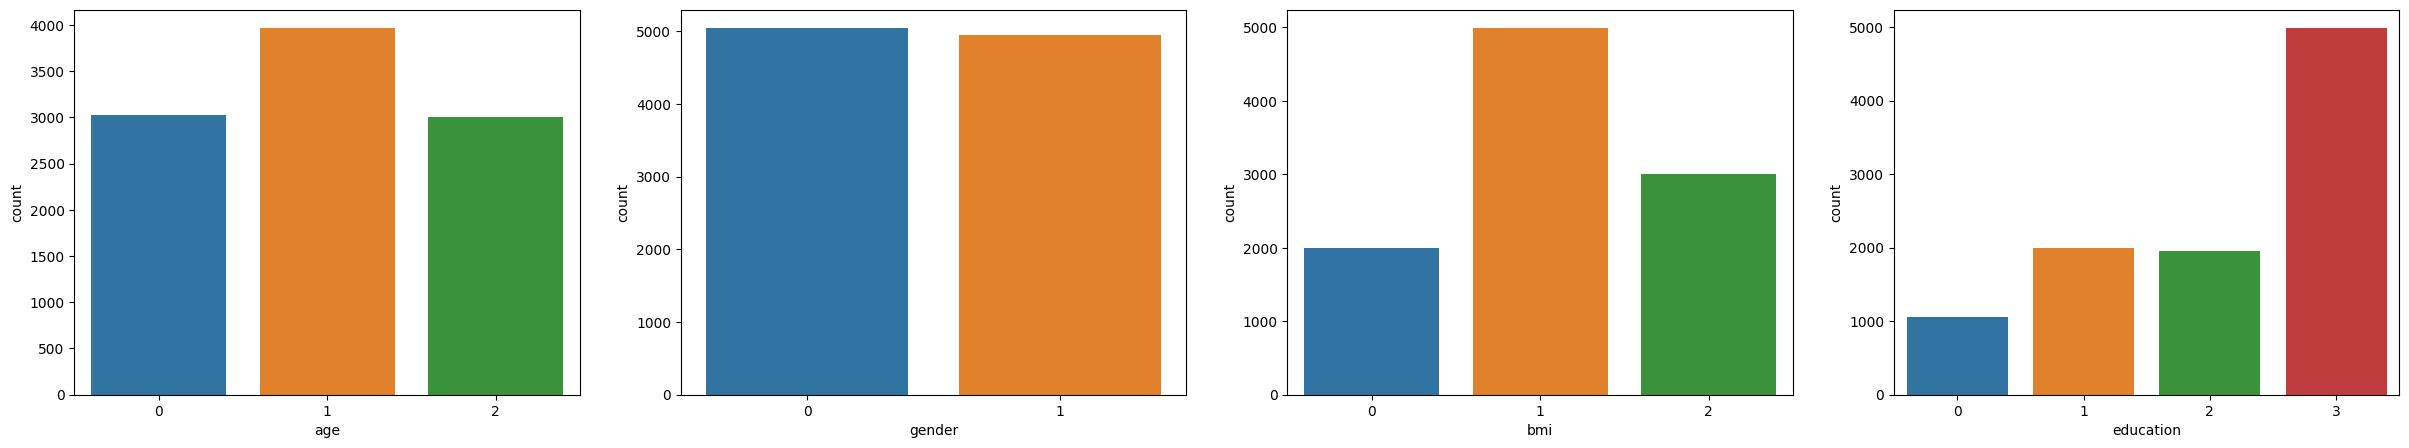

In [ ]:
f,axes=plt.subplots(1,4,figsize=(30,5))
sns.countplot(x='age',data=df2,ax=axes[0])
sns.countplot(x='gender',data=df2,ax=axes[1])
sns.countplot(x='bmi',data=df2,ax=axes[2])
sns.countplot(x='education',data=df2,ax=axes[3])
#sns.countplot(x='age',data=df,ax=axes[0])
plt.show()

<Axes: xlabel='tobacco', ylabel='count'>

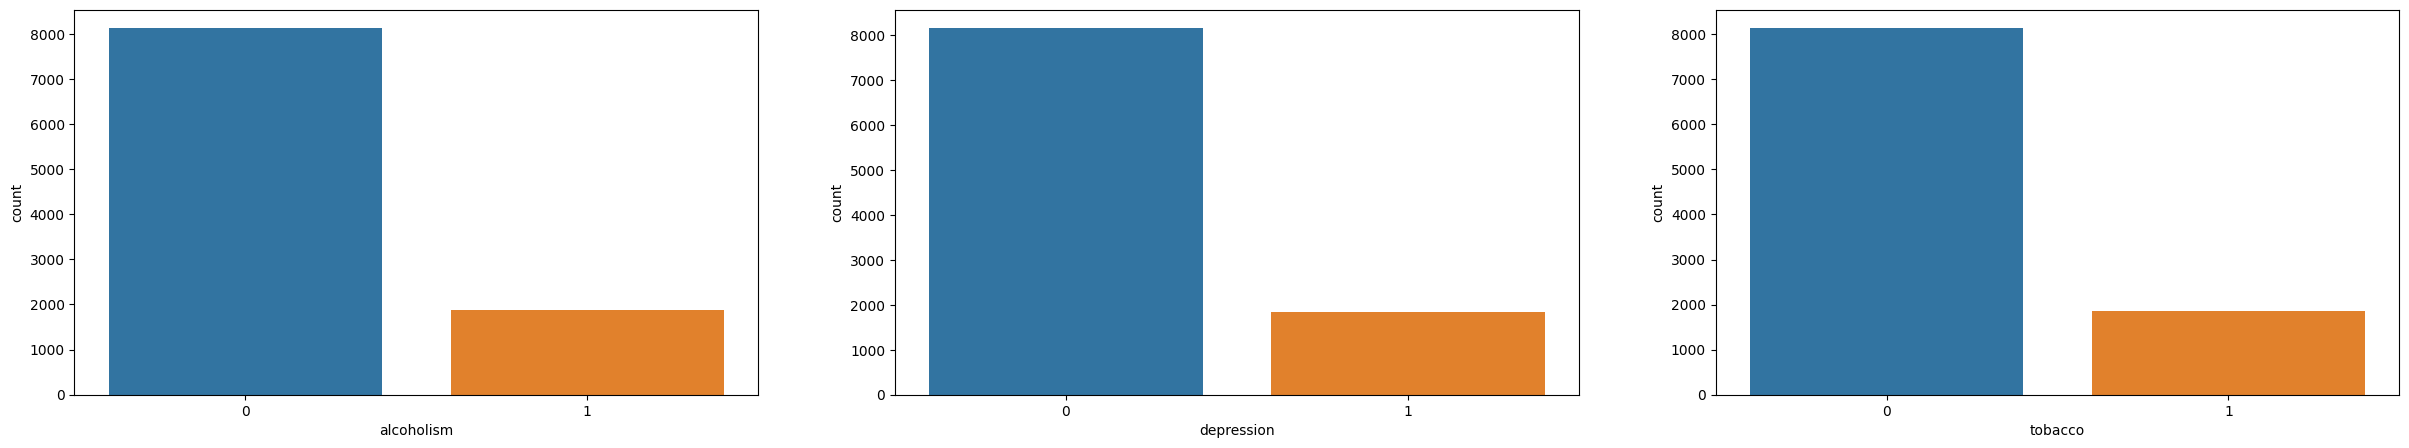

In [ ]:
f,axes=plt.subplots(1,3,figsize=(30,5))
sns.countplot(x='alcoholism',data=df2,ax=axes[0])
sns.countplot(x='depression',data=df2,ax=axes[1])
sns.countplot(x='tobacco',data=df2,ax=axes[2])

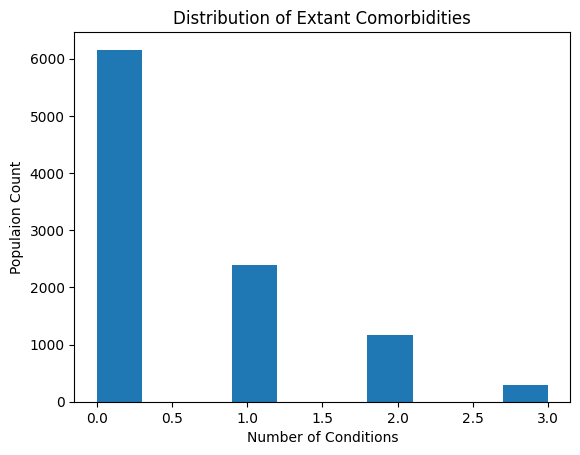

In [ ]:
plt.hist(df2['num_conditions'])
plt.xlabel('Number of Conditions')
plt.ylabel('Populaion Count')
plt.title('Distribution of Extant Comorbidities')
plt.show()

In [ ]:
print(df2['alcoholism'].value_counts())
print(df2['depression'].value_counts())
print(df2['tobacco'].value_counts())
print(df2['alcohol_only'].value_counts())
print(df2['depression_only'].value_counts())
print(df2['tobacco_only'].value_counts())
print(df2['alcoholism+depression'].value_counts())
print(df2['alcoholism+tobacco'].value_counts())
print(df2['depression+tobacco'].value_counts())
print(df2['tobacco+alcohol+smoking'].value_counts())

0    8126
1    1874
Name: alcoholism, dtype: int64
0    8153
1    1847
Name: depression, dtype: int64
0    8135
1    1865
Name: tobacco, dtype: int64
0    9187
1     813
Name: alcohol_only, dtype: int64
0    9214
1     786
Name: depression_only, dtype: int64
0    9206
1     794
Name: tobacco_only, dtype: int64
0    9620
1     380
Name: alcoholism+depression, dtype: int64
0    9610
1     390
Name: alcoholism+tobacco, dtype: int64
0    9610
1     390
Name: depression+tobacco, dtype: int64
0    9709
1     291
Name: tobacco+alcohol+smoking, dtype: int64


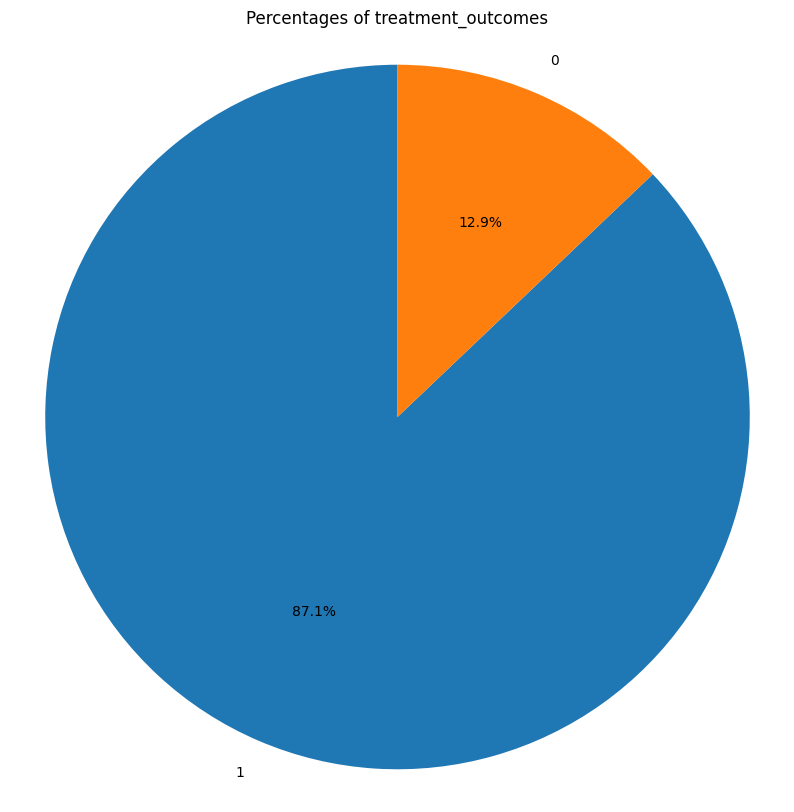

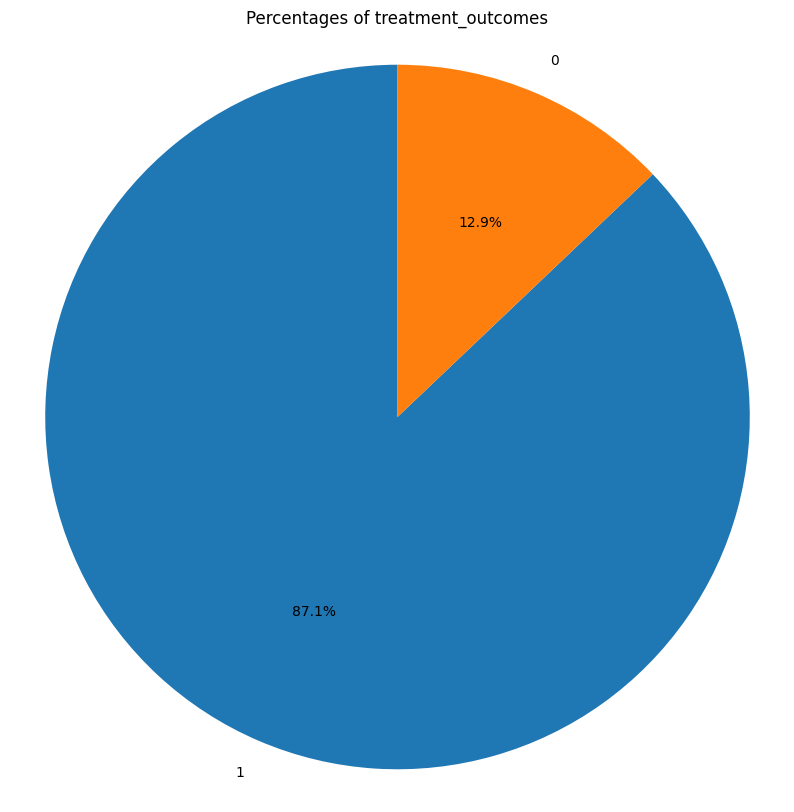

In [ ]:
counts = df2['treatment_outcomes'].value_counts()
percentages = counts / counts.sum()
labels = percentages.index
sizes = percentages.values
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentages of treatment_outcomes")
plt.show()
counts = df2['treatment_outcomes'].value_counts()
percentages = counts / counts.sum()
labels = percentages.index
sizes = percentages.values
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentages of treatment_outcomes")
plt.show()


In [ ]:
px.histogram(df2,x='treatment_outcomes',color='bmi',height=500,width=1000)

In [ ]:
px.histogram(df2,x='treatment_outcomes',color='Intervention',height=1000,width=1000)

###Power Analysis

In [ ]:
power_analysis=TTestIndPower()
results=pd.DataFrame({
    'Effect Size':[np.nan],'Samples':[np.nan],'Power':[np.nan]
})

In [ ]:
def statspower(df,x,y,case_no):
 """ x = value of treatment variable (gives us idea of the population - na, a, nt, t, adt, etc)
    y = value of control variable """
#  csv_file= create_dataset("size","percentage_alcoholism", "percentage_depression", "percentage_tobacco","percentage_alcoholism_depression",  "percentage_tobacco_alcoholism", "percentage_tobacco_depression", "percentage_tobacco_alcoholism_depression","treatment_noth,treatment_1_conditions","treatment_2_conditions","treatment_3_conditions","treatment_intervention","age","gender","bmi","edu","seed")
 #df= pd.read_csv("D:\tb_api\data.csv")
 #power_analysis=TTestIndPower()
#  results=pd.DataFrame({'Effect Size':[np.nan],'Samples':[np.nan],'Power':[np.nan]})
 treatment_arr=[]
 control_arr=[]
 treatment_locs=np.where((df['Intervention']==x))
 control_locs=np.where((df['Intervention']==y))
 for i in treatment_locs:
     treatment_arr.append(df['treatment_outcomes'].iloc[i])
 for j in control_locs:
     control_arr.append(df['treatment_outcomes'].iloc[j])
 l1 = len(treatment_arr[0])
 l2 = len(control_arr[0])
 index_treatment=np.arange(0,l1)
 index_control=np.arange(0,l2)
 treatment_df=pd.DataFrame({'idx':index_treatment,"Treatment":treatment_arr[0]})
 control_df=pd.DataFrame({'idx':index_control,"Control":control_arr[0]})
 mu1=treatment_df['Treatment'].mean()
 mu2=control_df['Control'].mean()
 std1=treatment_df['Treatment'].std()
 std2=control_df['Control'].std()
 s = np.sqrt(((l1 - 1) * std1 + (l2 - 1) * std2) / (l1 + l2 - 2))
 d = (mu1 - mu2) / s #cohen's effect size
 effect = round(d,2)
 sample_size=power_analysis.solve_power(effect_size=effect,alpha=0.05,power=0.8,alternative='two-sided')
 #power_analysis.solve_power()
 power=power_analysis.power(effect_size=effect,alpha=0.05,nobs1=l1,ratio=(l1/l2),alternative='two-sided')
 #power_analysis.power()
 #power=power_analysis.power()
 t=Counter(treatment_arr[0])
 c=Counter(control_arr[0])
 print('Case No:',case_no)
 print('Outcomes in Treatment array',t)
 print('Outcomes in Control array',c)
 #print(c)
 print('The effect size is =',effect)
 print('The required sample size =',sample_size)
 print('The current statistical power is',power)
 power_analysis.plot_power(dep_var='nobs',nobs=np.arange(5, sample_size),
                          effect_size=np.array([effect-(0.2*effect), effect,effect+(0.2*effect)]),
                          alpha=0.05)
 return

In [ ]:
power_analysis=TTestIndPower()
def calculate_power(x, y, df):
    treatment_arr=[]
    control_arr=[]
    treatment_locs=np.where((df['Intervention']==x))
    control_locs=np.where((df['Intervention']==y))
    for i in treatment_locs:
        treatment_arr.append(df['treatment_outcomes'].iloc[i])
    for j in control_locs:
        control_arr.append(df['treatment_outcomes'].iloc[j])
    l1 = len(treatment_arr[0])
    l2 = len(control_arr[0])
    index_treatment=np.arange(0,l1)
    index_control=np.arange(0,l2)
    treatment_df=pd.DataFrame({'idx':index_treatment,"Treatment":treatment_arr[0]})
    control_df=pd.DataFrame({'idx':index_control,"Control":control_arr[0]})
    mu1=treatment_df['Treatment'].mean()
    mu2=control_df['Control'].mean()
    std1=treatment_df['Treatment'].std()
    std2=control_df['Control'].std()
    s = np.sqrt(((l1 - 1) * std1 + (l2 - 1) * std2) / (l1 + l2 - 2))
    d = (mu1 - mu2) / s #cohen's effect size
    eff = round(d,2)
    p = power_analysis.power(effect_size=eff,alpha=0.05,nobs1=l1,ratio=(l1/l2),alternative='two-sided')
    return p

Case No: 1
Outcomes in Treatment array Counter({1: 355, 0: 42})
Outcomes in Control array Counter({1: 336, 0: 61})
The effect size is = 0.08
The required sample size = 2453.7296790644054
The current statistical power is 0.2030965834800599
Case No: 2
Outcomes in Treatment array Counter({1: 382, 0: 38})
Outcomes in Control array Counter({1: 311, 0: 82})
The effect size is = 0.2
The required sample size = 393.4056989990335
The current statistical power is 0.8371424277306075
Case No: 3
Outcomes in Treatment array Counter({1: 371, 0: 50})
Outcomes in Control array Counter({1: 291, 0: 74})
The effect size is = 0.14
The required sample size = 801.8656399922287
The current statistical power is 0.5557434880442144
Case No: 4
Outcomes in Treatment array Counter({1: 149, 0: 31})
Outcomes in Control array Counter({1: 140, 0: 60})
The effect size is = 0.2
The required sample size = 393.4056989990335
The current statistical power is 0.4529393065380194
Case No: 5
Outcomes in Treatment array Counter({1

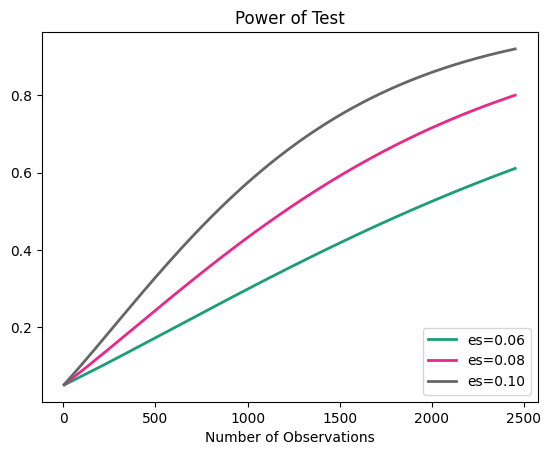

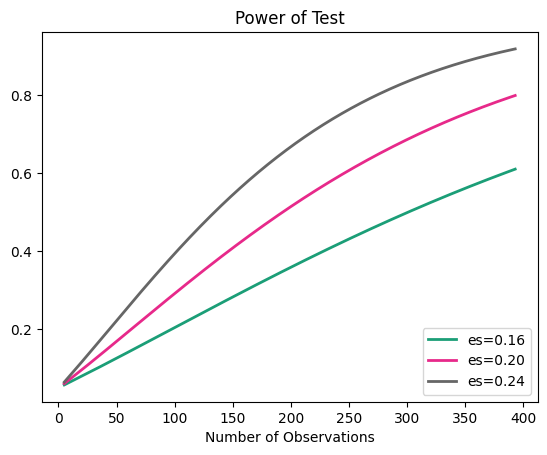

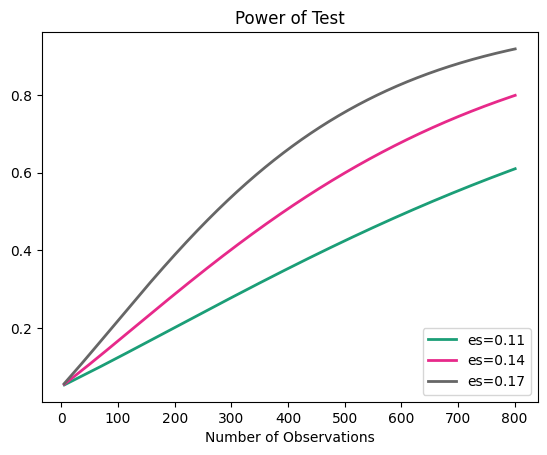

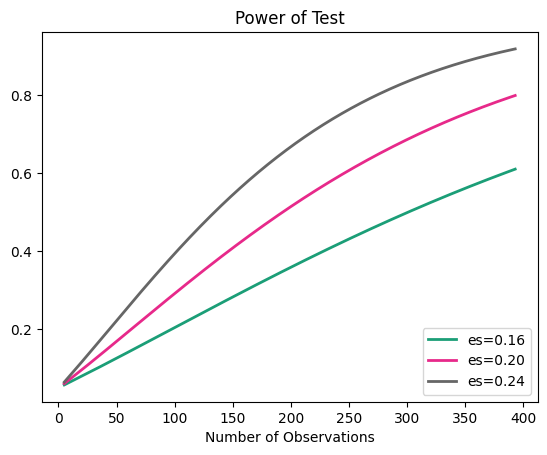

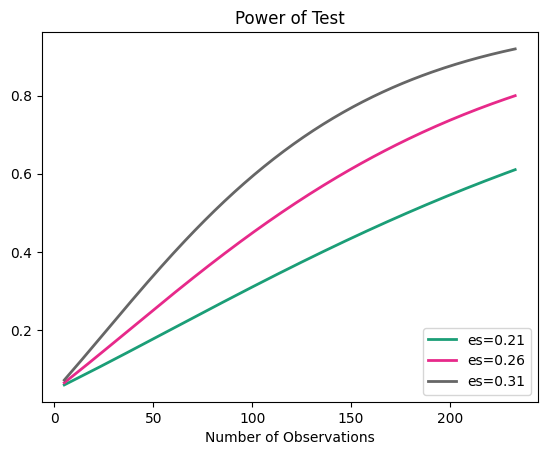

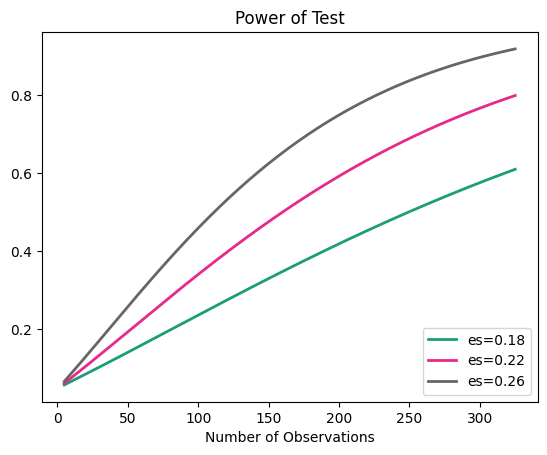

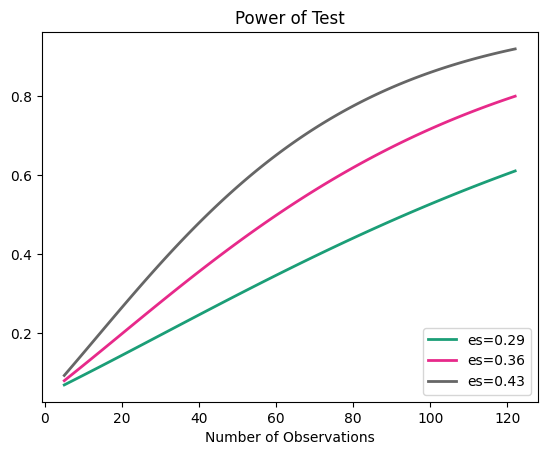

In [ ]:
statspower(df2,'T','NT',1)
statspower(df2,'A','NA',2)
statspower(df2,'M','NM',3)
statspower(df2,'AM','NAM',4)
statspower(df2,'AT','NAT',5)
statspower(df2,'MT','NMT',6)
statspower(df2,'AMT','NAMT',7)

###Backtracking and Resimulation of Power Corrected Data

In [ ]:
def check_sample_sizes(dfx):
  sample_sizes={}
  sample_sizes['Alcohol']=calculate_power('A','NA',dfx)
  sample_sizes['Depression']=calculate_power('M','NM',dfx)
  sample_sizes['Tobacco']=calculate_power('T','NT',dfx)
  sample_sizes['Alcohol-Depression']=calculate_power('AM','NAM',dfx)
  sample_sizes['Alcohol-Tobacco']=calculate_power('AT','NAT',dfx)
  sample_sizes['Depression-Tobacco']=calculate_power('MT','NMT',dfx)
  sample_sizes['Alcohol-Depression-Tobacco']=calculate_power('AMT','NAMT',dfx)
  #for i in sample_sizes.values():
  all_above_threshold = all(value >= 0.8 for value in sample_sizes.values())
  print(all_above_threshold)
  print(sample_sizes.values())
  return sample_sizes.values
check_sample_sizes(df2)

False
dict_values([0.8371424277306075, 0.5557434880442144, 0.2030965834800599, 0.4529393065380194, 0.7260734684115648, 0.5776417847557108, 0.832164032576718])


<function dict.values>

In [ ]:
create_dataset2()

TypeError: ignored

In [ ]:
power_analysis=TTestIndPower()
def calculate_power(x, y, df):
    treatment_arr=[]
    control_arr=[]
    treatment_locs=np.where((df['Intervention']==x))
    control_locs=np.where((df['Intervention']==y))
    for i in treatment_locs:
        treatment_arr.append(df['treatment_outcomes'].iloc[i])
    for j in control_locs:
        control_arr.append(df['treatment_outcomes'].iloc[j])
    l1 = len(treatment_arr[0])
    l2 = len(control_arr[0])
    index_treatment=np.arange(0,l1)
    index_control=np.arange(0,l2)
    treatment_df=pd.DataFrame({'idx':index_treatment,"Treatment":treatment_arr[0]})
    control_df=pd.DataFrame({'idx':index_control,"Control":control_arr[0]})
    mu1=treatment_df['Treatment'].mean()
    mu2=control_df['Control'].mean()
    std1=treatment_df['Treatment'].std()
    std2=control_df['Control'].std()
    s = np.sqrt(((l1 - 1) * std1 + (l2 - 1) * std2) / (l1 + l2 - 2))
    d = (mu1 - mu2) / s #cohen's effect size
    eff = round(d,2)
    p = power_analysis.power(effect_size=eff,alpha=0.05,nobs1=l1,ratio=(l1/l2),alternative='two-sided')
    return p

def try_sample_sizes2(dfx):
    sample_sizes = {}
    sample_sizes['Alcohol'] = calculate_power('A', 'NA', dfx)
    sample_sizes['Depression'] = calculate_power('M', 'NM', dfx)
    sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
    sample_sizes['Alcohol-Depression'] = calculate_power('AM', 'NAM', dfx)
    sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
    sample_sizes['Depression-Tobacco'] = calculate_power('MT', 'NMT', dfx)
    sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('AMT', 'NAMT', dfx)

    size = dfx.shape[0]
    #total_power = sum(sample_sizes.values())
    all_above_threshold = all(value >= 0.75 for value in sample_sizes.values())
    if not all_above_threshold:
        if sample_sizes['Alcohol'] < 0.75:
            size += 100
        elif sample_sizes['Depression'] < 0.75:
            size += 100
        elif sample_sizes['Tobacco'] < 0.75:
            size += 100
        elif sample_sizes['Alcohol-Depression'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Depression-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.75:
            size += 20

        dfx = create_dataset2(size,0.08,0.08,0.08,0.04,0.04,0.04,0.03,0.9,0.80,0.70,0.60,age=[0.3,0.4,0.3],gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        return try_sample_sizes2(dfx)

    # while all(value > 0.80 for value in sample_sizes.values()):
    #     for group in sample_sizes.keys():
    #         if sample_sizes[group] > 0.95:
    #             size -= 2000
    #             dfx = create_dataset2(size,0.08,0.08,0.08,0.04,0.04,0.04,0.03,0.9,0.80,0.70,0.60,age=[0.3,0.4,0.3],gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
    #             return try_sample_sizes2(dfx)
    return dfx
df_21=try_sample_sizes2(df2)

In [ ]:
df_21=try_sample_sizes2(df2)

In [ ]:
df_21.shape[0] #number of samples after resimulation

In [ ]:
check_sample_sizes(df_21)

###Creating Clinical Dataset

In [ ]:
def clinical_ss(dfx):
  counts= dfx['Intervention'].value_counts()[1]

  max_unaffected= dfx['Intervention'].value_counts()[0]
  column_name = 'Intervention'

  condition = dfx[column_name] == 'UNAFFECTED'
  selected_rows = dfx[condition]

  new_value = 'unaffected'
  count_to_reduce = max_unaffected - (max_unaffected-counts)
  count_reduced = 0

  for index, row in selected_rows.iterrows():
      if count_reduced < count_to_reduce:
          dfx.at[index, column_name] = new_value
          count_reduced += 1
      else:
          break
  condition = dfx['Intervention'] != 'UNAFFECTED'
  clinical = dfx[condition]

  clinical = clinical.dropna()
  return clinical

In [ ]:
clinical_data= clinical_ss(df_21) #unaffected rows dropped
clinical_data

In [ ]:
print(clinical_data.shape[0])
print(df_21.shape[0])

In [ ]:
df_21['Intervention'].value_counts()

In [ ]:
clinical_data['Intervention'].value_counts()

###MISCL

In [ ]:
def try_sample_sizes2(dfx):
    sample_sizes = {}
    sample_sizes['Alcohol'] = calculate_power('A', 'NA', dfx)
    sample_sizes['Depression'] = calculate_power('M', 'NM', dfx)
    sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
    sample_sizes['Alcohol-Depression'] = calculate_power('AM', 'NAM', dfx)
    sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
    sample_sizes['Depression-Tobacco'] = calculate_power('MT', 'NMT', dfx)
    sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('AMT', 'NAMT', dfx)

    size = dfx.shape[0]
    #total_power = sum(sample_sizes.values())
    all_above_threshold = all(value >= 0.75 for value in sample_sizes.values())
    if not all_above_threshold:
        if sample_sizes['Alcohol'] < 0.75:
            size += 100
        elif sample_sizes['Depression'] < 0.75:
            size += 100
        elif sample_sizes['Tobacco'] < 0.75:
            size += 100
        elif sample_sizes['Alcohol-Depression'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Depression-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.75:
            size += 20

        dfx = create_dataset2(size,0.08,0.08,0.08,0.04,0.04,0.04,0.03,0.9,0.80,0.70,0.60,age=[0.3,0.4,0.3],gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        return try_sample_sizes2(dfx)

    # while all(value > 0.80 for value in sample_sizes.values()):
    #     for group in sample_sizes.keys():
    #         if sample_sizes[group] > 0.95:
    #             size -= 2000
    #             dfx = create_dataset2(size,0.08,0.08,0.08,0.04,0.04,0.04,0.03,0.9,0.80,0.70,0.60,age=[0.3,0.4,0.3],gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
    #             return try_sample_sizes2(dfx)
    return dfx
df_21=try_sample_sizes2(df2)